2025-07-31 15:03:45.227 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-31 15:03:45.285 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-31 15:03:45.345 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-31 15:03:45.346 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-31 15:03:45.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-31 15:03:45.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-31 15:03:45.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

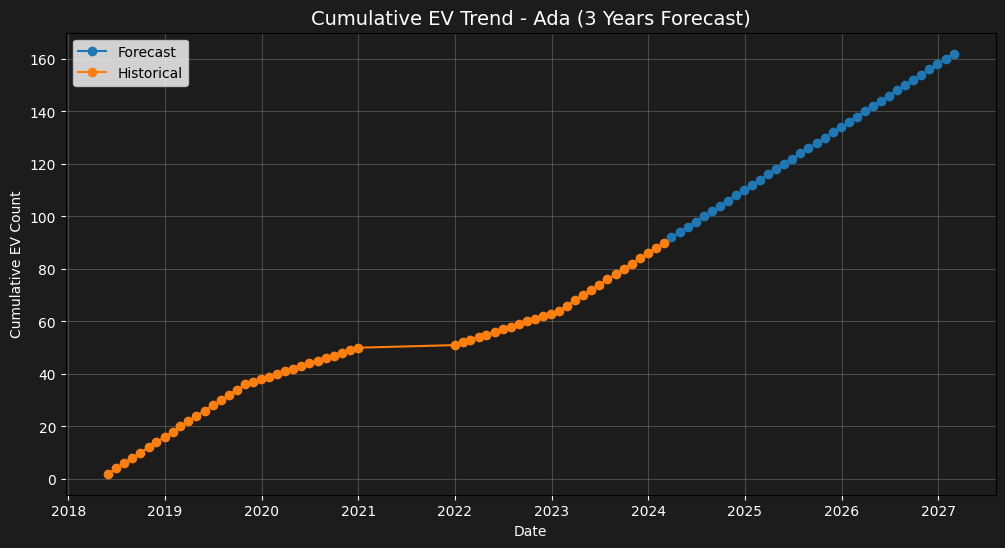

In [5]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import matplotlib.pyplot as plt

# Set Streamlit page config first thing
st.set_page_config(page_title="EV Forecast", layout="wide")

# === Load model ===
model = joblib.load('/content/forecasting_ev_model.pkl')

# === Styling ===
st.markdown("""
    <style>
        body {
            background-color: #fcf7f7;
            color: #000000;
        }
        .stApp {
            background: linear-gradient(to right, #c2d3f2, #7f848a);
        }
    </style>
""", unsafe_allow_html=True)

# Display image after config and styles
# Stylized title using markdown + HTML
st.markdown("""
    <div style='text-align: center; font-size: 36px; font-weight: bold; color: #FFFFFF; margin-top: 20px;'>
        🔮 EV Adoption Forecaster for a County in Washington State
    </div>
""", unsafe_allow_html=True)

# Welcome subtitle
st.markdown("""
    <div style='text-align: center; font-size: 22px; font-weight: bold; padding-top: 10px; margin-bottom: 25px; color: #FFFFFF;'>
        Welcome to the Electric Vehicle (EV) Adoption Forecast tool.
    </div>
""", unsafe_allow_html=True)

# Image
st.image("ev-car-factory.jpg", use_container_width=True)

# Instruction line
st.markdown("""
    <div style='text-align: left; font-size: 22px; padding-top: 10px; color: #FFFFFF;'>
        Select a county and see the forecasted EV adoption trend for the next 3 years.
    </div>
""", unsafe_allow_html=True)


# === Load data (must contain historical values, features, etc.) ===
@st.cache_data
def load_data():
    df = pd.read_csv("/content/preprocessed_ev_data.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    return df

df = load_data()

# === County dropdown ===
county_list = sorted(df['County'].dropna().unique().tolist())
county = st.selectbox("Select a County", county_list)

if county not in df['County'].unique():
    st.warning(f"County '{county}' not found in dataset.")
    st.stop()

county_df = df[df['County'] == county].sort_values("Date")
county_code = county_df['county_encoded'].iloc[0]

# === Forecasting ===
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
months_since_start = county_df['months_since_start'].max()
latest_date = county_df['Date'].max()

future_rows = []
forecast_horizon = 36

for i in range(1, forecast_horizon + 1):
    forecast_date = latest_date + pd.DateOffset(months=i)
    months_since_start += 1
    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    pred = model.predict(pd.DataFrame([new_row]))[0]
    future_rows.append({"Date": forecast_date, "Predicted EV Total": round(pred)})

    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

# === Combine Historical + Forecast for Cumulative Plot ===
historical_cum = county_df[['Date', 'Electric Vehicle (EV) Total']].copy()
historical_cum['Source'] = 'Historical'
historical_cum['Cumulative EV'] = historical_cum['Electric Vehicle (EV) Total'].cumsum()

forecast_df = pd.DataFrame(future_rows)
forecast_df['Source'] = 'Forecast'
forecast_df['Cumulative EV'] = forecast_df['Predicted EV Total'].cumsum() + historical_cum['Cumulative EV'].iloc[-1]

combined = pd.concat([
    historical_cum[['Date', 'Cumulative EV', 'Source']],
    forecast_df[['Date', 'Cumulative EV', 'Source']]
], ignore_index=True)

# === Plot Cumulative Graph ===
st.subheader(f"📊 Cumulative EV Forecast for {county} County")
fig, ax = plt.subplots(figsize=(12, 6))
for label, data in combined.groupby('Source'):
    ax.plot(data['Date'], data['Cumulative EV'], label=label, marker='o')
ax.set_title(f"Cumulative EV Trend - {county} (3 Years Forecast)", fontsize=14, color='white')
ax.set_xlabel("Date", color='white')
ax.set_ylabel("Cumulative EV Count", color='white')
ax.grid(True, alpha=0.3)
ax.set_facecolor("#1c1c1c")
fig.patch.set_facecolor('#1c1c1c')
ax.tick_params(colors='white')
ax.legend()
st.pyplot(fig)

# === Compare historical and forecasted cumulative EVs ===
historical_total = historical_cum['Cumulative EV'].iloc[-1]
forecasted_total = forecast_df['Cumulative EV'].iloc[-1]

if historical_total > 0:
    forecast_growth_pct = ((forecasted_total - historical_total) / historical_total) * 100
    trend = "increase 📈" if forecast_growth_pct > 0 else "decrease 📉"
    st.success(f"Based on the graph, EV adoption in **{county}** is expected to show a **{trend} of {forecast_growth_pct:.2f}%** over the next 3 years.")
else:
    st.warning("Historical EV total is zero, so percentage forecast change can't be computed.")


# === New: Compare up to 3 counties ===
st.markdown("---")
st.header("Compare EV Adoption Trends for up to 3 Counties")

multi_counties = st.multiselect("Select up to 3 counties to compare", county_list, max_selections=3)

if multi_counties:
    comparison_data = []

    for cty in multi_counties:
        cty_df = df[df['County'] == cty].sort_values("Date")
        cty_code = cty_df['county_encoded'].iloc[0]

        hist_ev = list(cty_df['Electric Vehicle (EV) Total'].values[-6:])
        cum_ev = list(np.cumsum(hist_ev))
        months_since = cty_df['months_since_start'].max()
        last_date = cty_df['Date'].max()

        future_rows_cty = []
        for i in range(1, forecast_horizon + 1):
            forecast_date = last_date + pd.DateOffset(months=i)
            months_since += 1
            lag1, lag2, lag3 = hist_ev[-1], hist_ev[-2], hist_ev[-3]
            roll_mean = np.mean([lag1, lag2, lag3])
            pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
            pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
            recent_cum = cum_ev[-6:]
            ev_slope = np.polyfit(range(len(recent_cum)), recent_cum, 1)[0] if len(recent_cum) == 6 else 0

            new_row = {
                'months_since_start': months_since,
                'county_encoded': cty_code,
                'ev_total_lag1': lag1,
                'ev_total_lag2': lag2,
                'ev_total_lag3': lag3,
                'ev_total_roll_mean_3': roll_mean,
                'ev_total_pct_change_1': pct_change_1,
                'ev_total_pct_change_3': pct_change_3,
                'ev_growth_slope': ev_slope
            }
            pred = model.predict(pd.DataFrame([new_row]))[0]
            future_rows_cty.append({"Date": forecast_date, "Predicted EV Total": round(pred)})

            hist_ev.append(pred)
            if len(hist_ev) > 6:
                hist_ev.pop(0)

            cum_ev.append(cum_ev[-1] + pred)
            if len(cum_ev) > 6:
                cum_ev.pop(0)

        hist_cum = cty_df[['Date', 'Electric Vehicle (EV) Total']].copy()
        hist_cum['Cumulative EV'] = hist_cum['Electric Vehicle (EV) Total'].cumsum()

        fc_df = pd.DataFrame(future_rows_cty)
        fc_df['Cumulative EV'] = fc_df['Predicted EV Total'].cumsum() + hist_cum['Cumulative EV'].iloc[-1]

        combined_cty = pd.concat([
            hist_cum[['Date', 'Cumulative EV']],
            fc_df[['Date', 'Cumulative EV']]
        ], ignore_index=True)

        combined_cty['County'] = cty
        comparison_data.append(combined_cty)

    # Combine all counties data for plotting
    comp_df = pd.concat(comparison_data, ignore_index=True)

    # Plot
    st.subheader("📈 Comparison of Cumulative EV Adoption Trends")
    fig, ax = plt.subplots(figsize=(14, 7))
    for cty, group in comp_df.groupby('County'):
        ax.plot(group['Date'], group['Cumulative EV'], marker='o', label=cty)
    ax.set_title("EV Adoption Trends: Historical + 3-Year Forecast", fontsize=16, color='white')
    ax.set_xlabel("Date", color='white')
    ax.set_ylabel("Cumulative EV Count", color='white')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor("#1c1c1c")
    fig.patch.set_facecolor('#1c1c1c')
    ax.tick_params(colors='white')
    ax.legend(title="County")
    st.pyplot(fig)

    # Display % growth for selected counties ===
    growth_summaries = []
    for cty in multi_counties:
        cty_df = comp_df[comp_df['County'] == cty].reset_index(drop=True)
        historical_total = cty_df['Cumulative EV'].iloc[len(cty_df) - forecast_horizon - 1]
        forecasted_total = cty_df['Cumulative EV'].iloc[-1]

        if historical_total > 0:
            growth_pct = ((forecasted_total - historical_total) / historical_total) * 100
            growth_summaries.append(f"{cty}: {growth_pct:.2f}%")
        else:
            growth_summaries.append(f"{cty}: N/A (no historical data)")

    # Join all in one sentence and show with st.success
    growth_sentence = " | ".join(growth_summaries)
    st.success(f"Forecasted EV adoption growth over next 3 years — {growth_sentence}")

st.success("Forecast complete")

st.markdown("Prepared for the **AICTE Internship Cycle 2 by S4F**")


In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00
